# Домашнее задание

### ИАД. 2024-2025

### Прогнозирование временных рядов

Мы постарались составить домашнее задание так, чтобы оно помогло закрепить все то, что мы прошли за 2 недели на лекциях и семинарах. Вы вольны использовать любые библиотеки, которые вам нравятся. Главное — это осознанность в выборе методов и интерпретации выводов.

В рамках домашнего задания будем работать с датасетом `NN5`, который можно скачать [здесь](https://zenodo.org/records/4656117). Временные ряды в этом датасете представляют собой данные по ежедневным снятиям наличных в банкоматах в Великобритании.

### Задание 1. Первичный анализ данных (1 балл)

In [111]:
%pip install -q statsforecast

In [112]:
import logging

logger = logging.getLogger(__name__)
import sys

c_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(c_handler)
logging.basicConfig(level=logging.INFO, force=True)

import random
import warnings
from datetime import datetime
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from statsforecast import StatsForecast, models
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

warnings.filterwarnings("ignore")

In [113]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)


seed_everything()

In [194]:
def mase(
    forecast: np.ndarray,
    insample: np.ndarray,
    outsample: np.ndarray,
    frequency: int,
) -> np.ndarray:
    """MASE loss as defined in "Scaled Errors" https://robjhyndman.com/papers/mase.pdf

    Args:
        forecast: Forecast values. Shape: batch, time_o
        insample: Insample values. Shape: batch, time_i
        outsample: Target values. Shape: batch, time_o
        frequency: Frequency value
    Returns:
        Same shape array with error calculated for each time step
    """
    return np.mean(np.abs(forecast - outsample)) / np.mean(
        np.abs(insample[:-frequency] - insample[frequency:])
    )

Нам пригодятся уже знакомые функции с семинаров по чтению рядов в формате tsf. Напомню, что иногда временные ряды могут быть представлены в tsf формате. Это такая структура данных, которая позволяет хранить метаинформацию о временных рядах, а также пары "первая дата — все значения временного ряда".

Функции позволяют считать данные в tsf формате и перевести их в формат, которым мы можем пользоваться.

In [115]:
def convert_tsf_to_dataframe(
    full_file_path_and_name: str,
    replace_missing_vals_with: Any = "NaN",
    value_column_name: str = "series_value",
) -> tuple[pd.DataFrame, str, int, str, str]:
    """
    Конвертирует файл формата TSF в pandas DataFrame.

    Args:
        full_file_path_and_name: Путь к файлу формата TSF.
        replace_missing_vals_with: Значение для замены пропусков.
        value_column_name: Имя столбца для значений временных рядов.

    Returns:
        DataFrame с данными временных рядов.
        Частота данных.
        Прогнозируемый горизонт.
        Содержат ли данные пропуски.
        Равны ли длины временных рядов.

    """
    col_names = []
    col_types = []
    all_data = {}
    all_series = []
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    data_started = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            if line.startswith("@"):
                if line.startswith("@data"):
                    data_started = True
                    # Инициализируем словарь для данных атрибутов
                    for col in col_names:
                        all_data[col] = []
                else:
                    parts = line.split(" ")
                    if line.startswith("@attribute"):
                        col_names.append(parts[1])
                        col_types.append(parts[2])
                    elif line.startswith("@frequency"):
                        frequency = parts[1]
                    elif line.startswith("@horizon"):
                        forecast_horizon = int(parts[1])
                    elif line.startswith("@missing"):
                        contain_missing_values = parts[1].lower() in (
                            "y",
                            "yes",
                            "t",
                            "true",
                            "on",
                            "1",
                        )
                    elif line.startswith("@equallength"):
                        contain_equal_length = parts[1].lower() in (
                            "y",
                            "yes",
                            "t",
                            "true",
                            "on",
                            "1",
                        )
            elif not line.startswith("#") and data_started:
                parts = line.split(":")
                # Последняя часть содержит значения ряда
                series_vals = parts[-1].split(",")
                numeric_series = [
                    replace_missing_vals_with if val == "?" else float(val) for val in series_vals
                ]
                all_series.append(pd.Series(numeric_series).array)
                # Преобразуем и сохраняем значения атрибутов
                for i in range(len(col_names)):
                    if col_types[i] == "numeric":
                        all_data[col_names[i]].append(int(parts[i]))
                    elif col_types[i] == "string":
                        all_data[col_names[i]].append(parts[i])
                    elif col_types[i] == "date":
                        all_data[col_names[i]].append(
                            datetime.strptime(parts[i], "%Y-%m-%d %H-%M-%S")
                        )

    all_data[value_column_name] = all_series
    loaded_data = pd.DataFrame(all_data)
    return loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length


def date_to_daterange(x: pd.Series, freq: str) -> pd.Series:
    """
    Преобразует временные метки в диапазон дат.

    Args:
        x: Временные метки.
        freq: Частота.

    Returns:
        pd.Series с диапазоном дат.

    """
    return pd.Series(pd.date_range(start=x.iloc[0], periods=len(x), freq=freq))


def convert_tsf_to_multivariate_or_standard_format(
    tsf_data_path: str,
    target_column: str = "series_value",
    date_from_column: str = "start_timestamp",
    id_column: str = "series_name",
    # one from ["multivariate", "standard"]
    format: str = "multivariate",
) -> pd.DataFrame:
    """
    Преобразует данные формата TSF в формат pandas DataFrame:
        если format == "standard" -> датафрейм с колонками "id", "date" и "value"
        если format == "multivariate" -> pivot таблица c date в качестве индекса,
            id в качестве колонок и значениями из value_column_name

    Args:
        tsf_data_path: Путь к файлу формата TSF.
        target_column: Имя столбца с целевой переменной.
        date_from_column: Имя столбца с переменной дат.
        id_column: Имя столбца с идентификаторами временных рядов.
        format: Формат данных ("multivariate" или "standard").

    Returns:
        pd.DataFrame с данными в формате "id", "date" и "value".

    """
    FREQ_MAP = {
        "monthly": "MS",
        "10_minutes": "10min",
        "half_hourly": "30min",
        "minutely": "1min",
        "daily": "D",
        "weekly": "7D",
        "yearly": "YS",
        "quarterly": "QS",
        "hourly": "H",
    }

    tsf_df, freq = convert_tsf_to_dataframe(tsf_data_path)[:2]

    # Преобразуем списки в {target_column} в "длинный столбец" со значениями
    tsf_df = tsf_df.explode(target_column)
    # Заменим повторяющиеся значения даты в {date_column} на date_range
    tsf_df["date"] = (
        tsf_df.groupby(id_column, sort=False)[date_from_column]
        .apply(lambda x: date_to_daterange(x, FREQ_MAP[freq]))
        .values
    )
    tsf_df = tsf_df.drop(columns=date_from_column)
    # Переименуем колонки
    tsf_df = tsf_df.rename(columns={id_column: "id", target_column: "value"}).reset_index(
        drop=True
    )
    # Приведем {id_column} к численным значениям
    ids2num = dict(zip(tsf_df["id"].unique(), np.arange(tsf_df["id"].nunique())))
    tsf_df["id"] = tsf_df["id"].map(ids2num)

    if format == "standard":
        return tsf_df
    return pd.pivot_table(tsf_df, values="value", index="date", columns="id")

#### Задание 1.1: Загрузка данных (0 баллов)

Давайте скачаем датасет __NN5__ и загрузим его, воспользовавшись функцией `convert_tsf_to_multivariate_or_standard_format`.

In [116]:
!wget "https://zenodo.org/records/4656117/files/nn5_daily_dataset_without_missing_values.zip?download=1" -O nn5_daily_dataset_without_missing_values.zip
!unzip -o nn5_daily_dataset_without_missing_values.zip
!rm nn5_daily_dataset_without_missing_values.zip

--2025-05-18 17:45:27--  https://zenodo.org/records/4656117/files/nn5_daily_dataset_without_missing_values.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289779 (283K) [application/octet-stream]
Saving to: ‘nn5_daily_dataset_without_missing_values.zip’

nn5_daily_dataset_w 100%[===================>] 282.99K   361KB/s    in 0.8s    

2025-05-18 17:45:28 (361 KB/s) - ‘nn5_daily_dataset_without_missing_values.zip’ saved [289779/289779]

Archive:  nn5_daily_dataset_without_missing_values.zip
  inflating: nn5_daily_dataset_without_missing_values.tsf  


In [117]:
df = convert_tsf_to_multivariate_or_standard_format(
    "nn5_daily_dataset_without_missing_values.tsf", format="standard"
)
df.head()

id      value       date
0   0  13.407029 1996-03-18
1   0  14.725057 1996-03-19
2   0  20.564059 1996-03-20
3   0   34.70805 1996-03-21
4   0  26.629819 1996-03-22

#### Задание 1.2: Типы данных (0.3 балла)

Выведите типы данных в датасете. Проверьте, что они корректные: даты должны быть в формате datetime, id — object, а значения временных рядов — float. Если это не так, то исправьте их.

In [118]:
df['id'] = df['id'].astype('object')
df['value'] = df['value'].astype('float')
df['date'] = pd.to_datetime(df['date'])
df.dtypes

id               object
value           float64
date     datetime64[ns]
dtype: object

#### Задание 1.3: Пропуски (0.05 балла)

Проверьте, есть ли в данных пропуски. Если они есть, то заполните их предыдущими значениями. Если пропусков нет, то просто выведите сообщение об этом.

In [119]:
df.fillna(method='ffill', inplace=True)

#### Задание 1.4: Визуальный анализ временных рядов (0.4 балла)

Постройте линейные графики временных рядов. По оси X отложите время, по оси Y — значения временного ряда.

Используйте Plotly, чтобы можно было отложить сразу все временные ряды на одном графике.

In [120]:
fig = go.Figure()
seed_everything()
random_ids = df["id"].unique()

for i in random_ids:
    fig.add_trace(
        go.Scatter(x=df[df["id"] == i]["date"], y=df[df["id"] == i]["value"], name=str(i))
    )
fig.update_layout(title="NN5", xaxis_title="Date", yaxis_title="Value")
fig.show()

__Ответьте на следующие вопросы:__
- Какова частотность (frequency) данных?
- Выровнены ли временные ряды?
- Стационарны ли временные ряды? Если нет, то какие признаки нестационарности вы можете выделить?
- На какие группы можно разбить временные ряды по наличию общих признаков? Есть ли что-то, чем похожи все временные ряды?
- Есть ли в рядах выбросы? Как вы можете это определить?

**Ответ:**
- Частотность данных - ежедневная
- Временные ряды начинаются и заканчиваются в одних и тех же временных точках => они выровнены (да и в следующем задании написано, что они выровнены, так что тут и думать нечего).
- Судя по графику, средний уровень и размах колебаний выглядит +- постоянным (хотя есть отдельные всплески), что свидетельствует о стационарности временных рядов (можно заметить, что присутствуют регулярные пики +- каждую неделю, что указывает на присутствующую сезонность, но тем временем тренд отсутствует).
- Все ряды имеют примерно одинаковый вид (регулярные повторяющиеся пики +- каждую неделю и отсутствие тренда), поэтому делить на группы в данном случае целесообразно по амплитуде колебаний и среднему уровню (некоторые ряды имеют больший разброс и в целом больший средний уровень, чем другие).
- Да, выбросы присутствуют (их можно отличить на графике, как неповторяющиеся отдельные большие пики в сравнении с основными значениями рядов).

#### Задание 1.5: Выделение тестовой выборки (0.25 балла)

Выделите 10% данных для теста, а остальные 90% оставьте для обучения. Делайте это очень аккуратно, чтобы не нарушить временную и многомерную структуру данных!

Вспомните и напишите, в чем особенность выделения тестовой выборки в задаче прогнозирования временных рядов и в задаче прогнозирования __многомерных__ временных рядов.

Обратите внимание, что временные ряды выровнены, а значит, в отличие от семинара, пробегаться в цикле по каждому id не нужно. Подумайте, как можно сделать это более эффективно.

In [121]:
df = df.sort_values(["id", "date"])
total_points = df.groupby("id").size().iloc[0]
train_size = int(np.floor(total_points * 0.9))

dates = np.sort(df["date"].unique())
split_date = dates[train_size]

train_df = df[df["date"] < split_date]
test_df = df[df["date"] >= split_date]

При делении выборки на обучающую и тестовую, мы не можем допустить "заглядывания в будущее", т.е. нельзя, чтобы в обучающую выборку попали точки после точек из тестовой. Поэтому берем конкретно последние по дате 10% точек для теста (т.к. ряды выровнены, мы можем это сделать). Что касается многомерных временных рядов, то для них важно не перемешивать данные между рядами, чтобы избежать "утечек".

### Задание 2. Полный анализ одного временного ряда (4 баллов)

#### Задание 2.1: Визуальный анализ (0.5 балла)

Выделите из данных временной ряд с номером 92. Постройте его линейный график.

In [122]:
train_data = train_df[train_df['id'] == 92]
test_data = test_df[test_df['id'] == 92]

fig = go.Figure()
seed_everything()
fig.add_trace(
    go.Scatter(x=train_data["date"], y=train_data["value"], name="Train", line=dict(color="blue"))
)
fig.add_trace(
    go.Scatter(x=test_data["date"], y=test_data["value"], name="Test", line=dict(color="red"))
)
fig.update_layout(
    title="Time Series 92", xaxis_title="Date", yaxis_title="Value"
)
fig.show()

Постройте графики автокорреляций (ACF) и частных автокорреляций (PACF) до 40-го лага для тренировочной выборки.

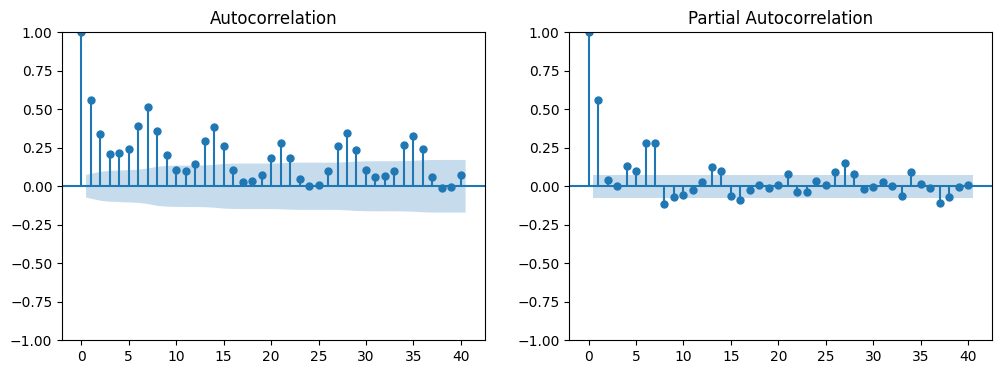

In [123]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train_data["value"], lags=40, ax=ax[0])
plot_pacf(train_data["value"], lags=40, ax=ax[1])
plt.show()

__Ответьте на следующие вопросы:__
- Стационарен ли временной ряд?
- Присутствует ли в нём тренд? Сезонность? Цикличность?
- Если ряд сезонный, то какой период выглядит наиболее вероятным?

**Ответ:**
- Автокорреляция медленно задухает, на многих (особенно на первых лагах) значения значительно выше доверительных границ. Схожая ситуация присутствует и на частной автокорреляции. Кроме того, судя по линейному графику, отсутствует тренд, а разброс постоянно меняется, что свидетельствует о нестационарности ряда.
- Явно выраженного тренда в данном временном ряду нет (было бы видно очень медленное затухание к большим лагам). Исходя из графиков можно сказать, что цикличности здесь нет (все колебания происходят +- каждую неделю, особенно это заметно на графике автокорреляции).
- Очевидные пики каждые 7 дней на графике автокорреляции говорят о **недельной** сезонности.

#### Задание 2.2: Построение модели SARIMA (2 балла)

Пользуясь правилами отсюда: https://people.duke.edu/~rnau/arimrule.htm, попробуйте подобрать параметры SARIMA модели, как мы делали это на семинаре.

Не забудьте о возможности использовать предобработку данных, например, логарифмирование и удаление выбросов (самое простое — это воспользоваться IQR: https://medium.com/@divyansh9144/iqr-interquartile-range-for-anomaly-detection-f9c568d1195f).

Если вы используете предобработку, то обязательно укажите, какую именно и почему.

**Важно:**
- Пользуясь правилом 1, вижу по графику, что есть длинная положительная автокорреляция на многих лагах => делаю дифференцирование.
- Пользуясь правилом 12, вижу недельную сезонность => также беру сезонное дифференцирование с периодом 7.   

In [137]:
new_train_data = train_data["value"].astype("float")
new_test_data = test_data["value"].astype("float")

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=train_data["date"], y=new_train_data, name="Clean Train", line=dict(color="blue"))
)
fig.update_layout(
    title="Train", xaxis_title="Date", yaxis_title="Value"
)
fig.show()

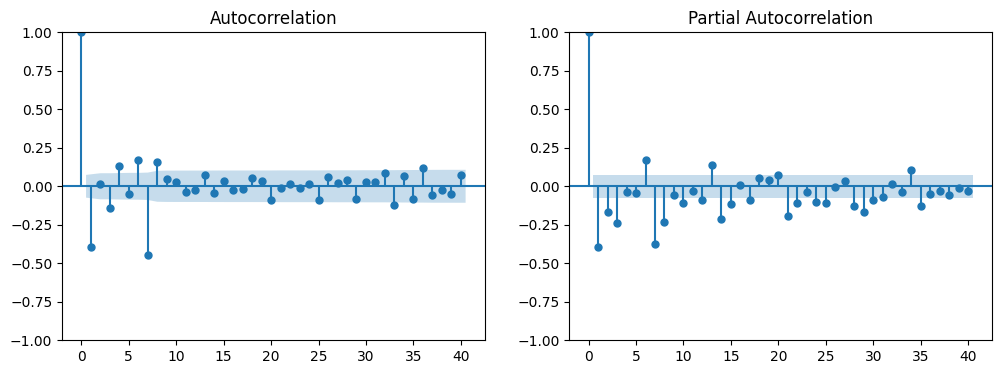

In [138]:
PERIOD = 7  # недельная сезонность
diff_seas_series = new_train_data.diff(PERIOD).dropna()
diff__diff_series = diff_seas_series.diff().dropna()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(diff__diff_series, lags=40, ax=ax[0])
plot_pacf(diff__diff_series, lags=40, ax=ax[1])
plt.show()

                                       SARIMAX Results                                        
Dep. Variable:                                  value   No. Observations:                  711
Model:             SARIMAX(2, 1, 1)x(0, 1, [1, 2], 7)   Log Likelihood               -2170.995
Date:                                Sun, 18 May 2025   AIC                           4353.989
Time:                                        18:22:42   BIC                           4381.183
Sample:                                             0   HQIC                          4364.511
                                                - 711                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3822      0.022     17.417      0.000       0.339       0.425
ar.

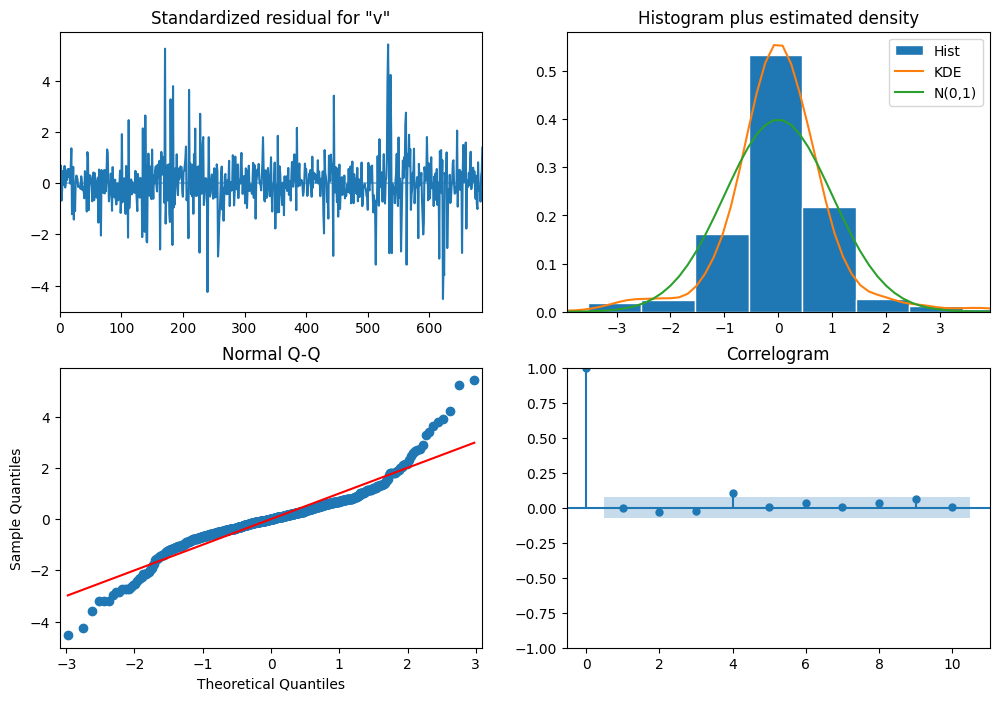

In [238]:
model = SARIMAX(
    new_train_data,
    order=(2, 1, 1),
    seasonal_order=(0, 1, 2, 7),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

model_fit = model.fit(disp=False)
print(model_fit.summary())

model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

#### Задание 2.3: Анализ остатков (0.5 баллов)

Постройте графики ACF и PACF остатков модели SARIMA. Проверьте, что в остатках нет значимых автокорреляций. Если они есть, то попробуйте объяснить, почему это происходит.

Проведите тест на стационарность остатков модели. Проведите тест на автокорреляцию остатков модели. Проинтерпретируйте результаты тестов. Если тесты показывают, что остатки нестационарны или в них есть автокорреляция, то попробуйте объяснить, почему это происходит.

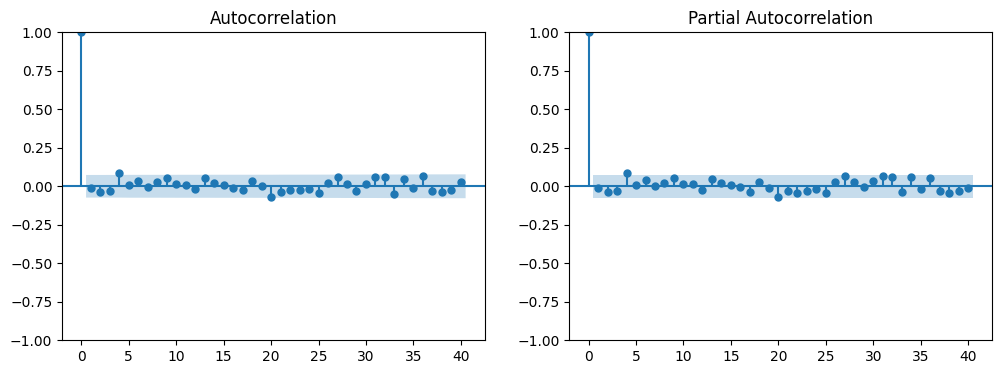

In [239]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(model_fit.resid, lags=40, ax=ax[0])
plot_pacf(model_fit.resid, lags=40, ax=ax[1])
plt.show()

In [240]:
# KPSS test
# H0: временной ряд стационарен
# H1: временной ряд не стационарен
statistic, p_value, lags, critical_values = kpss(model_fit.resid)
print(f"KPSS p-value: {p_value}")

# ADF test
# H0: unit root (не стационарен)
# H1: no unit root (стационарен)
statistic, p_value, usedlag, _, critical_values, icbest = adfuller(model_fit.resid)
print(f"ADF p-value: {p_value}")

# LB test
# H0: автокорреляция есть
# H1: автокорелляции нет
lb_test = acorr_ljungbox(model_fit.resid, lags=40, return_df=True)
print(f"{lb_test}")

KPSS p-value: 0.1
ADF p-value: 1.0880671268350924e-23
      lb_stat  lb_pvalue
1    0.061726   0.803789
2    0.952724   0.621039
3    1.525006   0.676511
4    7.105977   0.130393
5    7.169749   0.208319
6    8.068243   0.233146
7    8.090583   0.324674
8    8.625292   0.374885
9   10.609415   0.303434
10  10.797870   0.373481
11  10.853852   0.455587
12  11.146232   0.516430
13  13.392353   0.417982
14  13.826130   0.462743
15  13.904791   0.532762
16  14.013593   0.597701
17  14.428832   0.636548
18  15.249714   0.644755
19  15.250035   0.706579
20  18.607912   0.547428
21  19.537503   0.550701
22  19.944369   0.586520
23  20.405467   0.617345
24  20.596232   0.662415
25  22.151504   0.626981
26  22.578117   0.656690
27  25.557651   0.543241
28  25.768256   0.585781
29  26.335626   0.607502
30  26.535931   0.647519
31  29.376526   0.549630
32  31.936787   0.469884
33  33.885940   0.424620
34  35.762746   0.385605
35  35.875933   0.427219
36  38.930590   0.339226
37  39.567130   0.356

**Вывод:** остатки стационарны по KPSS (0.1 > 0.05 => H0) и по ADF (0.0 < 0.05 => H1). Автокорреляции остатков нет (для лагов до 40 lbvalue < 0.05 => H1). Значит модель хорошо описывает структуру временного ряда.

#### Задание 2.4: Получение прогнозов и выводы (1 балл)

С помощью полученной модели постройте прогноз на тестовую выборку.

Постройте график прогноза и фактических значений. Сделайте выводы о том, насколько хорошо модель предсказывает временной ряд.

Посчитайте метрику MASE, которую мы имплементировали в начале ноутбука. Объясните, что она показывает и почему ее потенциально полезнее использовать для сравнения моделей, чем MAE или MAPE. Выводы по самому значению метрики делать не нужно.

In [241]:
predicted_mean = model_fit.get_forecast(steps=len(new_test_data)).predicted_mean.reset_index(drop=True)
predictions = pd.DataFrame({"date": test_data["date"], "value": predicted_mean.values})

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=train_data["date"], y=train_data["value"], name="Train", line=dict(color="blue"))
)
fig.add_trace(
    go.Scatter(x=test_data["date"], y=test_data["value"], name="Test", line=dict(color="red"))
)
fig.add_trace(
    go.Scatter(x=predictions["date"], y=predictions["value"], name="Predictions", line=dict(color="green"))
)
fig.update_layout(
    title="Train/Test Split with Predictions", xaxis_title="Date", yaxis_title="Value"
)
fig.show()

mase_result = mase(predictions["value"].to_numpy(), train_data["value"].to_numpy(), test_data["value"].to_numpy(), 7)
print(f"MASE: {mase_result}")

MASE: 0.9922208067826354


**Вывод:** моя модель улавливает сезонность, но общий прогноз оставляет желать лучшего (уж слишком она сглаживает разброс). MASE показывает, что моя модель на 1% лучше наивного прогноза (это успех!). MASE сравнивает построенную модель с наивным прогнозом (< 1 - лучше, = 1 - идентична, > 1 - хуже). MASE лучше, чем MAE, так как она позволяет сравнивать ошибки между временными рядами разного масштаба. MASE лучше, чем MAPE, так как последняя сильно искажена на нулях и малых значениях.

### Задание 3. Построение бейзлайнов на всех рядах и автоматический подбор параметров (2 балла)

#### Задание 3.1: Запуск бейзлайнов (1 балл)
Давайте будем использовать statsforecast для бейзлайнов, так же как мы делали это на семинаре: https://nixtlaverse.nixtla.io/statsforecast/index.html

Постройте прогнозы на всех рядах с помощью следующих бейзлайнов:
- Naive
- Seasonal Naive
- AutoARIMA
- еще 2 на ваш выбор (например, ETS, Theta, TBATS или другие, которые вам нравятся). Кратко опишите суть выбранных моделей.

Выбрал Theta и TBATS:
- Theta - простая, но очень популярная конкурентная модель, использует модифицированное экспоненциальное сглаживание и часто служит бенчмарком на конкурсах прогнозирования временных рядов. Известна своей “стабильно хорошей” точностью на широких классах задач.
- TBATS умеет извлекать сложную и многократную сезонность, подходит для рядов с несколькими или нецелочисленными сезонными компонентами. Популярен в соревнованиях по прогнозированию.

In [260]:
# Переименуйте колонки, так как библиотека требует названия "unique_id", "y", "ds"
train_df = train_df.rename(columns={
    "id": "unique_id",
    "value": "y",
    "date": "ds",
})
train_df["ds"] = pd.to_datetime(train_df["ds"], format="%Y-%m-%d")
train_df["y"] = train_df["y"].astype("float")

# Инициализируйте модели
sf = StatsForecast(
    models=[
        models.Naive(),
        models.SeasonalNaive(season_length=7),
        models.AutoARIMA(season_length=7),
        models.TBATS(season_length=7),
        models.Theta(season_length=7),
    ],
    freq="D",
    n_jobs=-1,
    verbose=True,
)

# Получите прогнозы
forecasts_df = sf.forecast(df=train_df, h=len(test_data))
current_pred = forecasts_df[["unique_id", "ds", "SeasonalNaive", "Naive", "AutoARIMA", "TBATS", "Theta"]].copy()
current_pred = current_pred.rename(columns={"unique_id": "id", "ds": "date",})

current_pred_seas_naive = current_pred[["id", "date", "SeasonalNaive"]].rename(columns={"SeasonalNaive": "value"})
current_pred_naive = current_pred[["id", "date", "Naive"]].rename(columns={"Naive": "value"})
current_pred_arima = current_pred[["id", "date", "AutoARIMA"]].rename(columns={"AutoARIMA": "value"})
current_pred_tbats = current_pred[["id", "date", "TBATS"]].rename(columns={"TBATS": "value"})
current_pred_theta = current_pred[["id", "date", "Theta"]].rename(columns={"Theta": "value"})

Forecast:   0%|          | 0/111 [Elapsed: 00:00]

In [261]:
current_pred[current_pred["id"] == 92]

id       date  SeasonalNaive      Naive  AutoARIMA      TBATS      Theta
7360  92 1998-02-27      34.508154  39.347712  33.865412  33.201352  33.482344
7361  92 1998-02-28      23.829563  39.347712  27.233717  28.130703  27.704617
7362  92 1998-03-01      19.345082  39.347712  24.955404  25.596270  25.677853
7363  92 1998-03-02      19.410836  39.347712  24.906444  25.592254  25.320117
7364  92 1998-03-03      22.067333  39.347712  25.118190  24.954534  24.679052
...   ..        ...            ...        ...        ...        ...        ...
7435  92 1998-05-13      26.420305  39.347712  28.507664  29.676933  28.091108
7436  92 1998-05-14      39.347712  39.347712  28.528467  35.261778  33.014501
7437  92 1998-05-15      34.508154  39.347712  28.549271  35.548416  34.088695
7438  92 1998-05-16      23.829563  39.347712  28.570075  30.477768  28.310968
7439  92 1998-05-17      19.345082  39.347712  28.590878  27.943335  26.284204

[80 rows x 7 columns]

#### Задание 3.2: Анализ результатов (1 балл)

Постройте графики фактических значений и прогнозов для всех бейзлайнов для ряда 92. Выведите метрики MASE.

Что можно сказать о каждом из бейзлайнов? Какой из бейзлайнов лучше всего предсказывает временной ряд?

Смогли ли вы руками подобрать гиперпараметры для SARIMA модели лучше, чем автоматический подбор в библиотеке? Если да, то вы огромный молодец! Если нет, то не расстраивайтесь, так бывает.

In [265]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=train_data["date"], y=train_data["value"], name="Train", line=dict(color="blue")))
fig.add_trace(go.Scatter(x=test_data["date"], y=test_data["value"], name="Test", line=dict(color="red")))

fig.add_trace(go.Scatter(x=current_pred_naive[current_pred_naive['id'] == 92]['date'],
                         y=current_pred_naive[current_pred_naive['id'] == 92]['value'],
                         name='Naive', line=dict(color='gray')))
fig.add_trace(go.Scatter(x=current_pred_seas_naive[current_pred_seas_naive['id'] == 92]['date'],
                         y=current_pred_seas_naive[current_pred_seas_naive['id'] == 92]['value'],
                         name='SeasonalNaive', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=current_pred_arima[current_pred_arima['id'] == 92]['date'],
                         y=current_pred_arima[current_pred_arima['id'] == 92]['value'],
                         name='AutoARIMA', line=dict(color='green')))
fig.add_trace(go.Scatter(x=current_pred_tbats[current_pred_tbats['id'] == 92]['date'],
                         y=current_pred_tbats[current_pred_tbats['id'] == 92]['value'],
                         name='TBATS', line=dict(color='purple')))
fig.add_trace(go.Scatter(x=current_pred_theta[current_pred_theta['id'] == 92]['date'],
                         y=current_pred_theta[current_pred_theta['id'] == 92]['value'],
                         name='Theta', line=dict(color='brown')))

fig.update_layout(
    title="Time Series 92: Forecasts by Baselines",
    xaxis_title="Date", yaxis_title="Value"
)
fig.show()

In [267]:
y_train = train_data["value"].to_numpy()
y_test = test_data["value"].to_numpy()

mase_naive = mase(
    current_pred_naive[current_pred_naive["id"] == 92]["value"].to_numpy(),
    y_train,
    y_test,
    7
)
mase_seasonal_naive = mase(
    current_pred_seas_naive[current_pred_seas_naive["id"] == 92]["value"].to_numpy(),
    y_train,
    y_test,
    7
)
mase_arima = mase(
    current_pred_arima[current_pred_arima["id"] == 92]["value"].to_numpy(),
    y_train,
    y_test,
    7
)
mase_tbats = mase(
    current_pred_tbats[current_pred_tbats["id"] == 92]["value"].to_numpy(),
    y_train,
    y_test,
    7
)
mase_theta = mase(
    current_pred_theta[current_pred_theta["id"] == 92]["value"].to_numpy(),
    y_train,
    y_test,
    7
)

print(f"MASE Naive:           {mase_naive:.4f}")
print(f"MASE SeasonalNaive:   {mase_seasonal_naive:.4f}")
print(f"MASE AutoARIMA:       {mase_arima:.4f}")
print(f"MASE TBATS:           {mase_tbats:.4f}")
print(f"MASE Theta:           {mase_theta:.4f}")

MASE Naive:           2.6212
MASE SeasonalNaive:   1.1528
MASE AutoARIMA:       1.3737
MASE TBATS:           1.1838
MASE Theta:           1.1259


Лучше всего временной ряд предсказывает Theta, хуже всего Naive. Но у них у всех в сравнении с наивным прогнозом результат хуже (MASE > 1).


Постройте датафрейм с MASE для всех бейзлайнов (агрегированный по всем рядам). Какой из бейзлайнов лучше всего предсказывает временные ряды в нашем датасете? Какой из бейзлайнов хуже всего предсказывает временные ряды в нашем датасете? Как вы думаете, почему так происходит?

In [277]:
mase_scores = []

for series_id in df["id"].unique():
    train_ser = train_df[train_df["unique_id"] == series_id]["y"].values
    test_ser = test_df[test_df["id"] == series_id]["value"].values

    row_mase_naive = mase(
        forecast=current_pred_naive[current_pred_naive["id"] == series_id]["value"].values,
        insample=train_ser,
        outsample=test_ser,
        frequency=7
    )
    row_mase_seas_naive = mase(
        forecast=current_pred_seas_naive[current_pred_seas_naive["id"] == series_id]["value"].values,
        insample=train_ser,
        outsample=test_ser,
        frequency=7
    )
    row_mase_arima = mase(
        forecast=current_pred_arima[current_pred_arima["id"] == series_id]["value"].values,
        insample=train_ser,
        outsample=test_ser,
        frequency=7
    )
    row_mase_tbats = mase(
        forecast=current_pred_tbats[current_pred_tbats["id"] == series_id]["value"].values,
        insample=train_ser,
        outsample=test_ser,
        frequency=7
    )
    row_mase_theta = mase(
        forecast=current_pred_theta[current_pred_theta["id"] == series_id]["value"].values,
        insample=train_ser,
        outsample=test_ser,
        frequency=7
    )
    mase_scores.append({
        "id": series_id,
        "MASE_Naive": row_mase_naive,
        "MASE_SeasonalNaive": row_mase_seas_naive,
        "MASE_AutoARIMA": row_mase_arima,
        "MASE_TBATS": row_mase_tbats,
        "MASE_Theta": row_mase_theta,
    })

mase_df = pd.DataFrame(mase_scores)
mean_mase = mase_df[['MASE_Naive', 'MASE_SeasonalNaive', 'MASE_AutoARIMA', 'MASE_TBATS', 'MASE_Theta']].mean(numeric_only=True)
print("Средние MASE по бейзлайнам:")
print(mean_mase)

Средние MASE по бейзлайнам:
MASE_Naive            3.327772
MASE_SeasonalNaive    1.003310
MASE_AutoARIMA        0.854613
MASE_TBATS            1.054853
MASE_Theta            0.847817
dtype: float64


Лучше всего временные ряды на нашем датасете предсказывает Theta, потому что в ряду нет долгосрочных трендов или каких-то сложных циклов (только обычная сезонность). Хуже всего предсказывает Naive, видимо потому что он совсем не учитывает сезонность, которая здесь оказывает огромное влияние.

Постройте графики фактических значений и прогнозов самого сильного бейзлайна для еще 3-х каких-нибудь рядов и ответьте на следующие вопросы:
- Есть ли среди них такие, которые предсказываются хуже остальных?
- Есть ли среди них такие, которые предсказываются лучше остальных?

In [278]:
best_pred = current_pred_theta

random_ids = np.random.choice(df["id"].unique(), 3, replace=False)

for row_id in random_ids:
    train_row = train_df[train_df['unique_id'] == row_id]
    test_row = test_df[test_df['id'] == row_id]
    pred_row = best_pred[best_pred['id'] == row_id]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_row["ds"], y=train_row["y"], name="Train", line=dict(color="blue")))
    fig.add_trace(go.Scatter(x=test_row["date"], y=test_row["value"], name="Test", line=dict(color="red")))
    fig.add_trace(go.Scatter(x=pred_row["date"], y=pred_row["value"], name="AutoARIMA", line=dict(color="green")))
    fig.update_layout(
        title=f"Id {row_id}: Forecast by Theta",
        xaxis_title="Date",
        yaxis_title="Value"
    )
    fig.show()

- Для ряда 59 предсказание не очень: на тестовой части есть падения, которые модель совсем не смогла повторить, хотя они уже появлялись раньше в ряду, так что нельзя назвать их появление неожиданным.
- Для ряда 15 прогноз хорошо совпадает с фактическими значениями — модель хорошо схватывает сезонность и шум рядов, лишь чуть-чуть не попала в пики.
- Для ряда 73 предсказание в целом хорошее, но чуть сглажено — модель сделала верное предсказание, но не попала в амплитуду колебаний (разброс должен быть больше).

### Задание 4. ML & DL модели (3 балла)

Здесь хочется дать вам полную свободу действий.

Вам нужно будет выбрать одну из ML моделей и одну из DL моделей (старайтесь не повторять один в один решение из семинара, а, если повторяете, то попробуйте, например, перебрать параметры DL модели, оптимизации, препроцессинга / добавить экзогенные признаки (актуально для MIMO стратегии) и т. д.) и построить прогнозы для всех временных рядов на тестовой выборке. __Ваша цель (желательная, но необязательная) — улучшить MASE, полученный с помощью бейзлайнов.__

__Результат задания — мини-отчет по тому, что вы попробовали, что получилось и что не получилось.__ По одному баллу дается за работу с данными (предобработка, генерация дополнительных признаков), за применение ML и DL моделей и интерпретацию полученных с помощью них результатов. Не забудьте кратко описать суть выбранных моделей (особенно, если речь идет о DL моделях).

Вы можете использовать любые модели и библиотеки (`tsfresh` для извлечения признаков, `Tsururu` / `ETNA` / `darts` для использования предобработки, стратегий, моделей и т. д.).

In [ ]:
# --- Your code here --


Постройте графики фактических значений и прогнозов для всех бейзлайнов для ряда 92. Постройте графики фактических значений и прогнозов для 3-х рядов из предыдущего задания. Стали ли прогнозы лучше отражать реальность?

In [ ]:
# --- Your code here --